In [1]:
import re
import os
import time
import random
import numpy as np
from pandas import Series
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.api as sm
from fbprophet import Prophet
import itertools
import warnings
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [37]:
pd.plotting.register_matplotlib_converters()

In [2]:
from fbprophet import Prophet

In [290]:
def tim_sers(y,exog,dia=False,year_start=2018,title=0, dyn=False):
    '''
    prints the summary of the arima model and returns either
    dia=True: a plot of the diagnostics
    dia=False(default): a plot of the timeseries
    year_start: the year to start the prediction, default 2019
    
    '''

    mod = sm.tsa.statespace.SARIMAX(y,
                                    exog=exog,
                                    time_varying_regression=False,
                                    mle_regression=True,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

    if dia:
        results.plot_diagnostics(figsize=(18, 8))
        return plt.show()
    else:

        pred = results.get_prediction(start=pd.to_datetime('{}-01-31'.format(year_start)),
                                      end=pd.to_datetime('2021-12-31'),
                                      dynamic=dyn, 
                                      full_results=True)
        pred_ci = pred.conf_int()

        ax = y.plot(label='observed')

        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)
        ax.set_xlabel('Date')
        ax.set_ylabel('Search Interest')
        ax.grid()
        if title!=0:
            plt.title(title)
        plt.ylim(0,100)
        plt.xlim((pd.to_datetime('2009-12-31'),pd.to_datetime('2021-12-31')))
        plt.legend()
        # plt.axhline(30, color='black')
        return plt.show()

In [3]:
def plt_szn(df,szn='A',size='l',title=0):
    """
    simple plot with time scaled precision
    """
    
    if (size=='l'):
        df.resample(szn).mean().plot(figsize=(15,10),linewidth=3.0)
        if title !=0:
            plt.xlabel(title,fontsize=20)
    elif (size=='m'):
        df.resample(szn).mean().plot(figsize=(10,7),linewidth=2.0)
        if title !=0:
            plt.xlabel(title,fontsize=15)
    elif (size=='s'):
        df.resample(szn).mean().plot(figsize=(7,5),linewidth=1.0)
        if title !=0:
            plt.xlabel(title,fontsize=10)
    else:
        print('wrong size')
    if title !=0:
        plt.xlabel(title,fontsize=15)
    plt.axhline(0, color='black')

In [4]:
features=pd.read_csv('features',index_col=0)
features.index=pd.DatetimeIndex(features.index)

In [5]:
explore=pd.read_csv('daily09-19',index_col='date')
explore.index=pd.DatetimeIndex(explore.index)

In [8]:
data=pd.merge(explore['space exploration'],features,how='left', left_on=explore.index,right_on=features.index)
data.index=pd.DatetimeIndex(explore.index)
data.drop(labels='key_0',axis=1,inplace=True)

In [12]:
data['SciFi_Movies'].describe()

count    3683.000000
mean        1.803693
std         1.451466
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: SciFi_Movies, dtype: float64

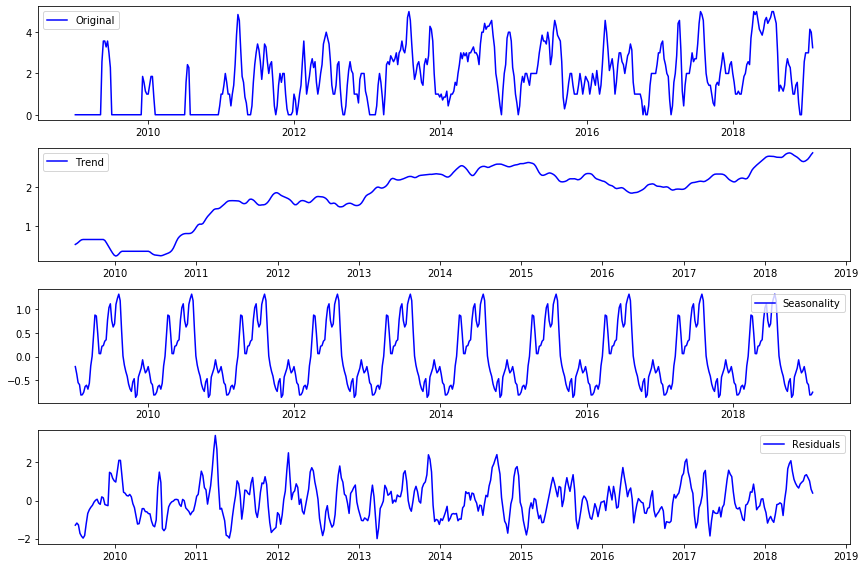

In [13]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
ts = data['SciFi_Movies'].resample('W',how='mean')
# ts = nasa['nasa'].resample('M',how='mean')
# ts = marscol['mars colonization'].resample('M').mean()


decomposition = seasonal_decompose(ts)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [15]:
year_groups = data['SciFi_Movies'].resample('M',how='mean').groupby(pd.Grouper(freq ='A'))


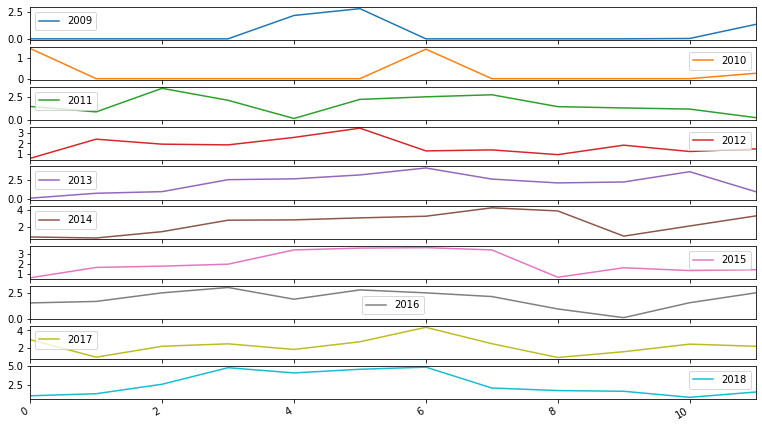

In [17]:
# year_groups = daily.groupby(pd.Grouper(freq ='A'))

#Create a new DataFrame and store yearly values in columns 
spc_annual = pd.DataFrame()
# yer=[]
# groop=[]
j=0
for yr, group in year_groups:
    if j<=9:
        spc_annual[yr.year]=group[:365].values.ravel()
    j+=1



# spc_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
spc_annual.plot(figsize = (13,8), subplots=True, legend=True);

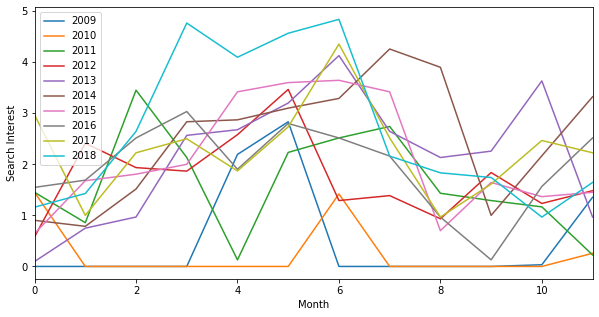

In [20]:
# using='Nasa'
spc_annual.plot(figsize = (10,5), subplots=False, legend=True);
plt.ylabel('Num Movies in top ')
plt.xlabel('Month')
plt.ylim(0,10)
# plt.ylim(top=60,bottom=5)
# plt.title('Seasonality of {} Google Searches'.format(using))
plt.show()

In [21]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

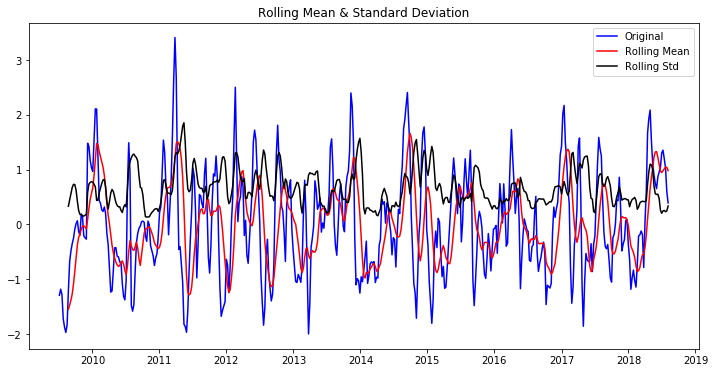

Results of Dickey-Fuller Test:
Test Statistic                -8.727866e+00
p-value                        3.251467e-14
#Lags Used                     2.000000e+00
Number of Observations Used    4.720000e+02
Critical Value (1%)           -3.444281e+00
Critical Value (5%)           -2.867683e+00
Critical Value (10%)          -2.570042e+00
dtype: float64


In [22]:
# Drop NaN values from residuals.
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(ts_log_decompose)

In [333]:
data.head()

,space exploration,Aero_Stocks,SciFi_Movies,Nasa_Budget
date,,,,
2009-01-01,0.00,0.000000,0.0,0.57
2009-01-02,40.88,-0.002049,0.0,0.57
2009-01-03,25.76,0.000000,0.0,0.57
2009-01-04,0.00,0.000000,0.0,0.57
2009-01-05,53.20,-0.002671,0.0,0.57


In [186]:
y=nasa['Space Exploration'][pd.to_datetime('2009-01-01'):].resample('M',how='mean')
exog=nasa['budget'][pd.to_datetime('2009-01-01'):].resample('M',how='mean')

In [161]:
space_exploration_2020=pd.read_csv('new_space_exploration',index_col=1)
space_exploration_2020.index=pd.DatetimeIndex(space_exploration_2020['date'])
space_exploration_2020.head()

,date,Space Exploration_monthly,isPartial,scale,Space Exploration
date,,,,,
2009-01-01,2009-01-01,53.0,False,0.53,0.00
2009-01-02,2009-01-02,53.0,NaN,0.53,0.00
2009-01-03,2009-01-03,53.0,NaN,0.53,0.00
2009-01-04,2009-01-04,53.0,NaN,0.53,0.00
2009-01-05,2009-01-05,53.0,NaN,0.53,41.87


In [155]:
nasa=nasa_2020.join(space_exploration_2020['Space Exploration'],how='left')

In [332]:
budget.head()

NameError: name 'budget' is not defined

In [204]:
budget_up

,budget,Space Exploration
day,,
2005-04-10,0.63,NaN
2005-04-11,0.63,NaN
2005-04-12,0.63,NaN
2005-04-13,0.63,NaN
2005-04-14,0.63,NaN
...,...,...
2021-12-27,0.50,NaN
2021-12-28,0.50,NaN
2021-12-29,0.50,NaN


In [203]:
budget_up=pd.read_csv('2021_budget_good',index_col=1)
budget_down=pd.read_csv('2021_budget_bad',index_col=1)
budget_up.drop(labels='Unnamed: 0',axis=1,inplace=True)
budget_down.drop(labels='Unnamed: 0',axis=1,inplace=True)
budget_up.index=pd.DatetimeIndex(budget_up.index)
budget_down.index=pd.DatetimeIndex(budget_down.index)
budget_up=budget_up.join(space_exploration_2020['Space Exploration'],how='left')
budget_down=budget_down.join(space_exploration_2020['Space Exploration'],how='left')

In [283]:
y_up=budget_up['Space Exploration'][pd.to_datetime('2009-01-01'):].resample('M',how='mean')
exog_up=budget_up['budget'][pd.to_datetime('2009-01-01'):].resample('M',how='mean')

In [284]:
y_down=budget_down['Space Exploration'][pd.to_datetime('2009-01-01'):].resample('M',how='mean')
exog_down=budget_down['budget'][pd.to_datetime('2009-01-01'):].resample('M',how='mean')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
budget        72.1151     96.429      0.748      0.455    -116.882     261.113
ar.L1          0.5007      0.118      4.258      0.000       0.270       0.731
ma.L1         -1.0000    187.257     -0.005      0.996    -368.017     366.017
ar.S.L12   -1.968e-05      0.224   -8.8e-05      1.000      -0.438       0.438
ma.S.L12      -0.7981      0.257     -3.108      0.002      -1.301      -0.295
sigma2        42.0690   7875.775      0.005      0.996   -1.54e+04    1.55e+04


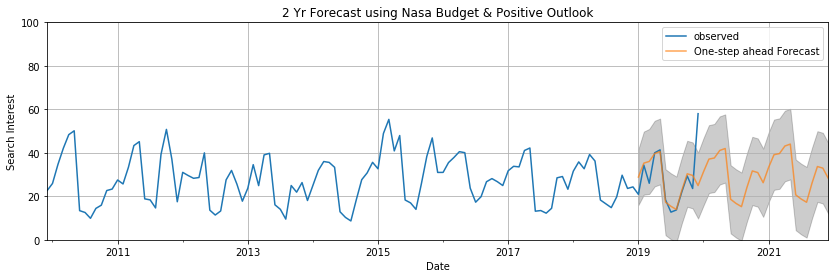

In [292]:

tim_sers(y_up,exog_up,
         dia=False,
         year_start=2019,
         title='2 Yr Forecast using Nasa Budget & Positive Outlook',
         dyn=True
        )

In [349]:
def tim_sers(y,exog,dia=False,year_start=2018,title=0, dyn=False):
    '''
    prints the summary of the arima model and returns either
    dia=True: a plot of the diagnostics
    dia=False(default): a plot of the timeseries
    year_start: the year to start the prediction, default 2019
    
    '''

    mod = sm.tsa.statespace.SARIMAX(y,
                                    exog=exog,
                                    time_varying_regression=False,
                                    mle_regression=True,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])

    if dia:
        results.plot_diagnostics(figsize=(18, 8))
        return plt.show()
    else:

        pred = results.get_prediction(start=pd.to_datetime('{}-01-31'.format(year_start)),
                                      end=pd.to_datetime('2018-12-31'),
                                      dynamic=dyn, 
                                      full_results=True)
        pred_ci = pred.conf_int()

        ax = y.plot(label='observed')

        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)
        ax.set_xlabel('Date')
        ax.set_ylabel('Search Interest')
        ax.grid()
        if title!=0:
            plt.title(title)
        plt.ylim(0,100)
        plt.xlim((pd.to_datetime('2014-12-31'),pd.to_datetime('2018-12-31')))
        plt.legend()
        # plt.axhline(30, color='black')
        return plt.show()

In [350]:
y=data['space exploration'].resample('M').mean()
exog=data[['Aero_Stocks','SciFi_Movies','Nasa_Budget']].resample('M').mean()

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Aero_Stocks     98.8319    653.164      0.151      0.880   -1181.347    1379.011
SciFi_Movies    -0.3531      0.721     -0.490      0.624      -1.767       1.061
Nasa_Budget   -129.5335    119.704     -1.082      0.279    -364.149     105.082
ar.L1            0.6264      0.090      6.949      0.000       0.450       0.803
ma.L1           -0.9999     23.379     -0.043      0.966     -46.822      44.822
ar.S.L12        -0.1638      0.147     -1.116      0.264      -0.451       0.124
ma.S.L12        -0.6328      0.171     -3.701      0.000      -0.968      -0.298
sigma2          34.5821    806.956      0.043      0.966   -1547.022    1616.187


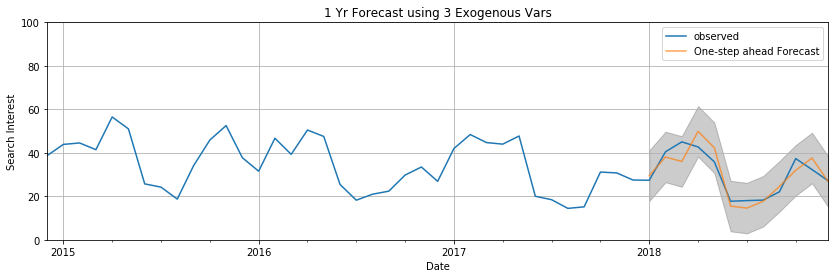

In [351]:
tim_sers(y,
         exog,
         year_start=2018,
         title='1 Yr Forecast using 3 Exogenous Vars',
         dyn=False
        )

In [329]:
def tim_sers2(y1,exog1,y2,exog2,dia=False,year_start=2018,title=0, dyn=False):
    '''
    prints the summary of the arima model and returns either
    dia=True: a plot of the diagnostics
    dia=False(default): a plot of the timeseries
    year_start: the year to start the prediction, default 2019
    
    '''

    mod1 = sm.tsa.statespace.SARIMAX(y1,
                                    exog=exog1,
                                    time_varying_regression=False,
                                    mle_regression=True,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results1 = mod1.fit()
    mod2 = sm.tsa.statespace.SARIMAX(y2,
                                    exog=exog2,
                                    time_varying_regression=False,
                                    mle_regression=True,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results2 = mod2.fit()
    print(results2.summary().tables[1])

    if dia:
        results.plot_diagnostics(figsize=(12, 6))
        return plt.show()
    else:

        pred1 = results1.get_prediction(start=pd.to_datetime('{}-01-31'.format(year_start)),
                                      end=pd.to_datetime('2021-12-31'),
                                      dynamic=dyn, 
                                      full_results=True)
        pred_ci1 = pred1.conf_int()
        pred2 = results2.get_prediction(start=pd.to_datetime('{}-01-31'.format(year_start)),
                                      end=pd.to_datetime('2021-12-31'),
                                      dynamic=dyn, 
                                      full_results=True)
        pred_ci2 = pred2.conf_int()

        ax = y1.plot(label='observed',linewidth=3)

        pred1.predicted_mean.plot(ax=ax, label='5% Increase in 2021 NASA Budget',
                                  alpha=.7,figsize=(12,6),linewidth=3)
        ax.fill_between(pred_ci1.index,
                        pred_ci1.iloc[:, 0],
                        pred_ci1.iloc[:, 1], color='k', alpha=.1)
        pred2.predicted_mean.plot(ax=ax, label='5% Decrease in 2021 NASA Budget',
                                  alpha=.7,linewidth=3)
        ax.fill_between(pred_ci2.index,
                        pred_ci2.iloc[:, 0],
                        pred_ci2.iloc[:, 1], color='k', alpha=.1)
        ax.set_xlabel('Date')
        ax.set_ylabel('Search Interest')
        ax.grid()
        if title!=0:
            plt.title(title)
        plt.ylim(0,100)
        plt.xlim((pd.to_datetime('2009-12-31'),pd.to_datetime('2021-12-31')))
        plt.legend()
        # plt.axhline(30, color='black')
        return plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
budget        72.1151     96.429      0.748      0.455    -116.882     261.113
ar.L1          0.5007      0.118      4.258      0.000       0.270       0.731
ma.L1         -1.0000    187.257     -0.005      0.996    -368.017     366.017
ar.S.L12   -1.968e-05      0.224   -8.8e-05      1.000      -0.438       0.438
ma.S.L12      -0.7981      0.257     -3.108      0.002      -1.301      -0.295
sigma2        42.0690   7875.775      0.005      0.996   -1.54e+04    1.55e+04


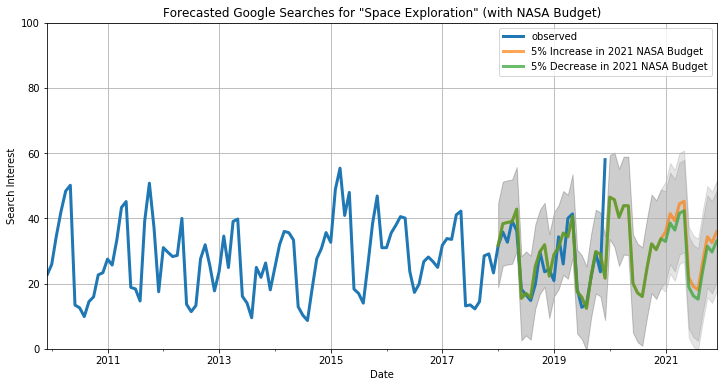

In [330]:
tim_sers2(y_up,exog_up,y_down,exog_down,title='Forecasted Google Searches for "Space Exploration" (with NASA Budget)')